In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data\PJME_hourly.csv')
df


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [4]:
df.Datetime = pd.to_datetime(df.Datetime)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [9]:
df = df.set_index('Datetime')

In [13]:
df.isna().sum()

PJME_MW    0
dtype: int64

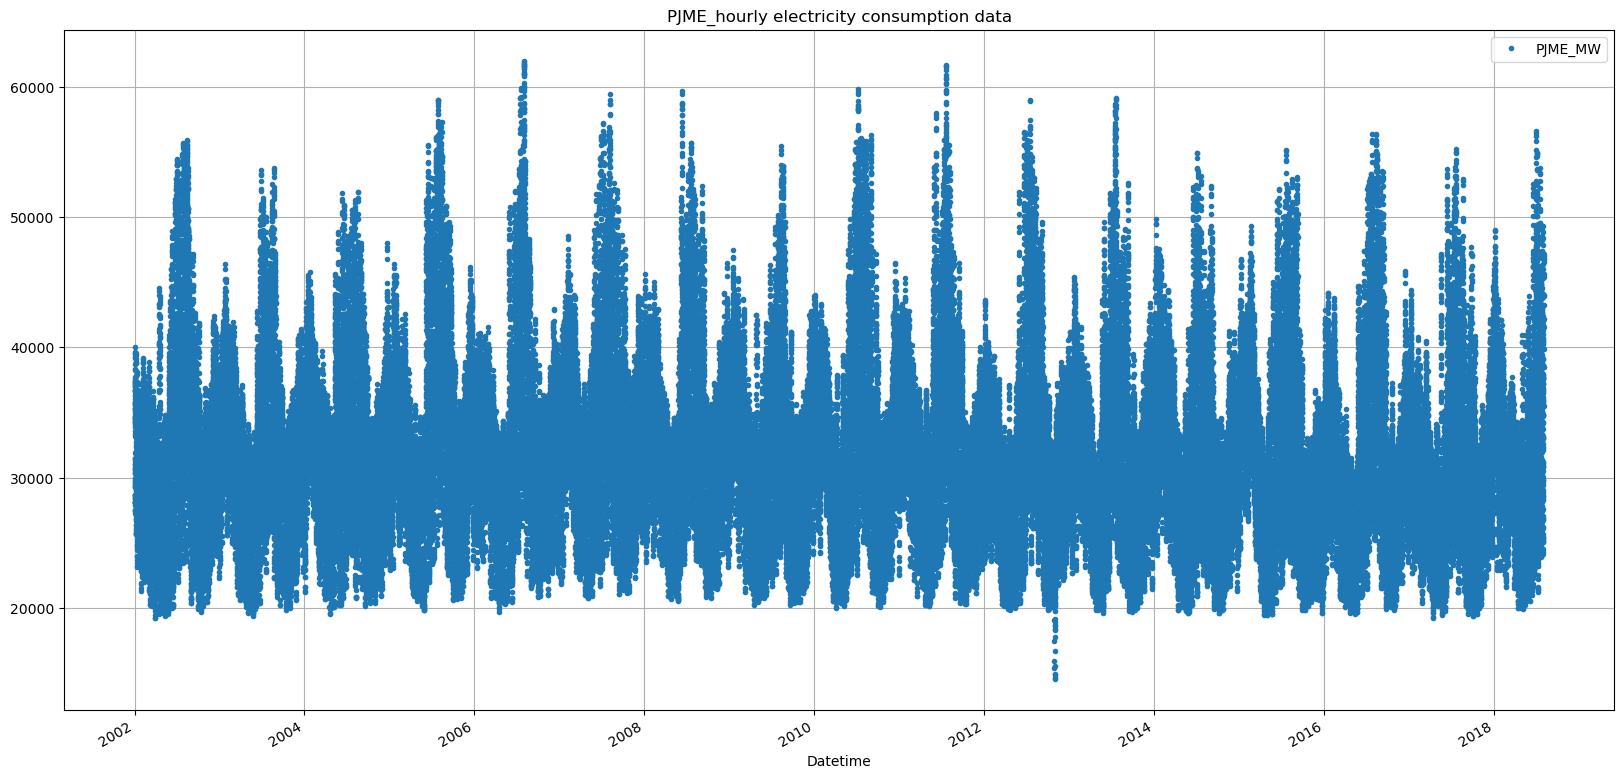

In [12]:
df.plot(style=".",
        figsize=(20,10),
        title='PJME_hourly electricity consumption data')
plt.grid(True)
plt.show()

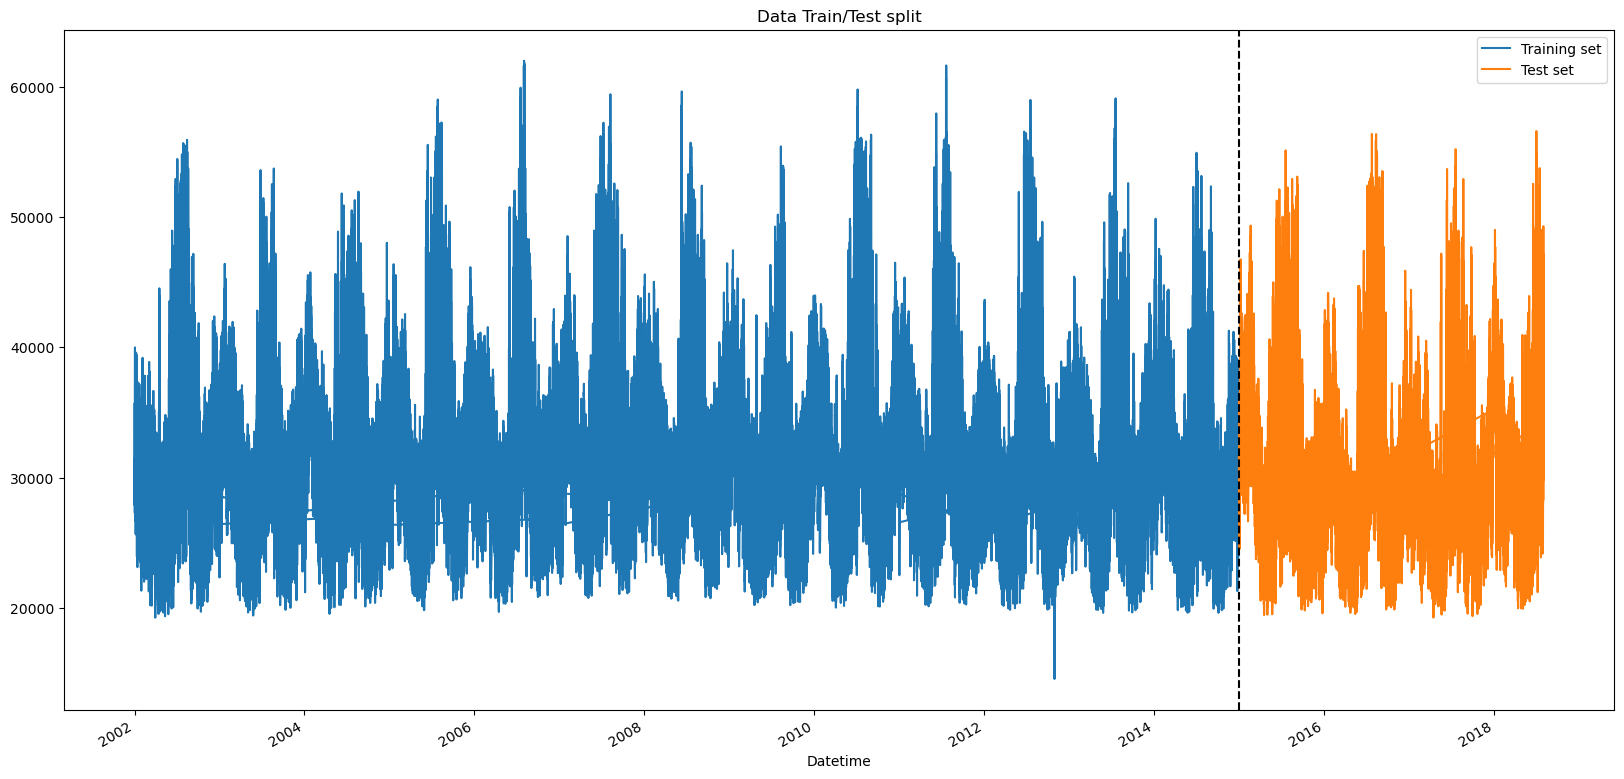

In [14]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(20,10))

train.plot(ax=ax, label='train', title="Data Train/Test split")
test.plot(ax=ax, label='test')
ax.axvline('01-01-2015', color='black', linestyle='--')
ax.legend(['Training set', 'Test set'])
plt.show()

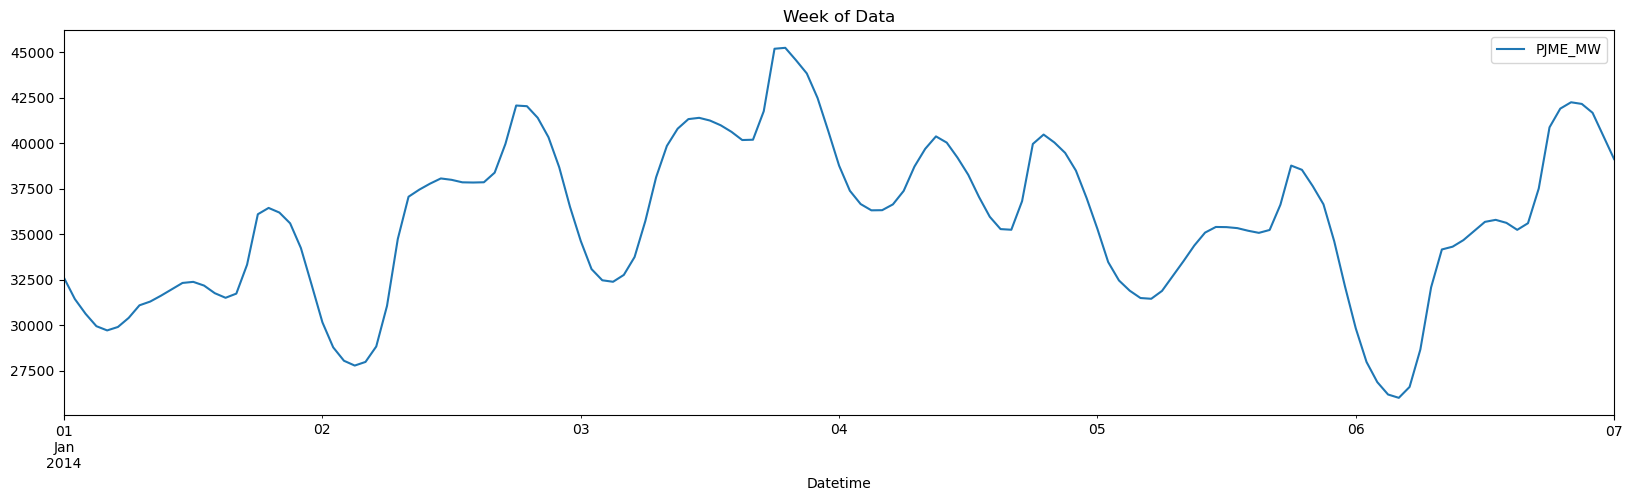

In [23]:
df.loc[(df.index >= '2014-01-01') & (df.index <= '2014-01-07')] \
    .sort_index() \
    .plot(figsize=(20, 5), title='Week of Data')
plt.show()


In [24]:
def create_features(df):
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['dayofweek'].isin([5, 6]) * 1
    return df
df = create_features(df)

In [30]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,0
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,0
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,0
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,0
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,0
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,0
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,0
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,0


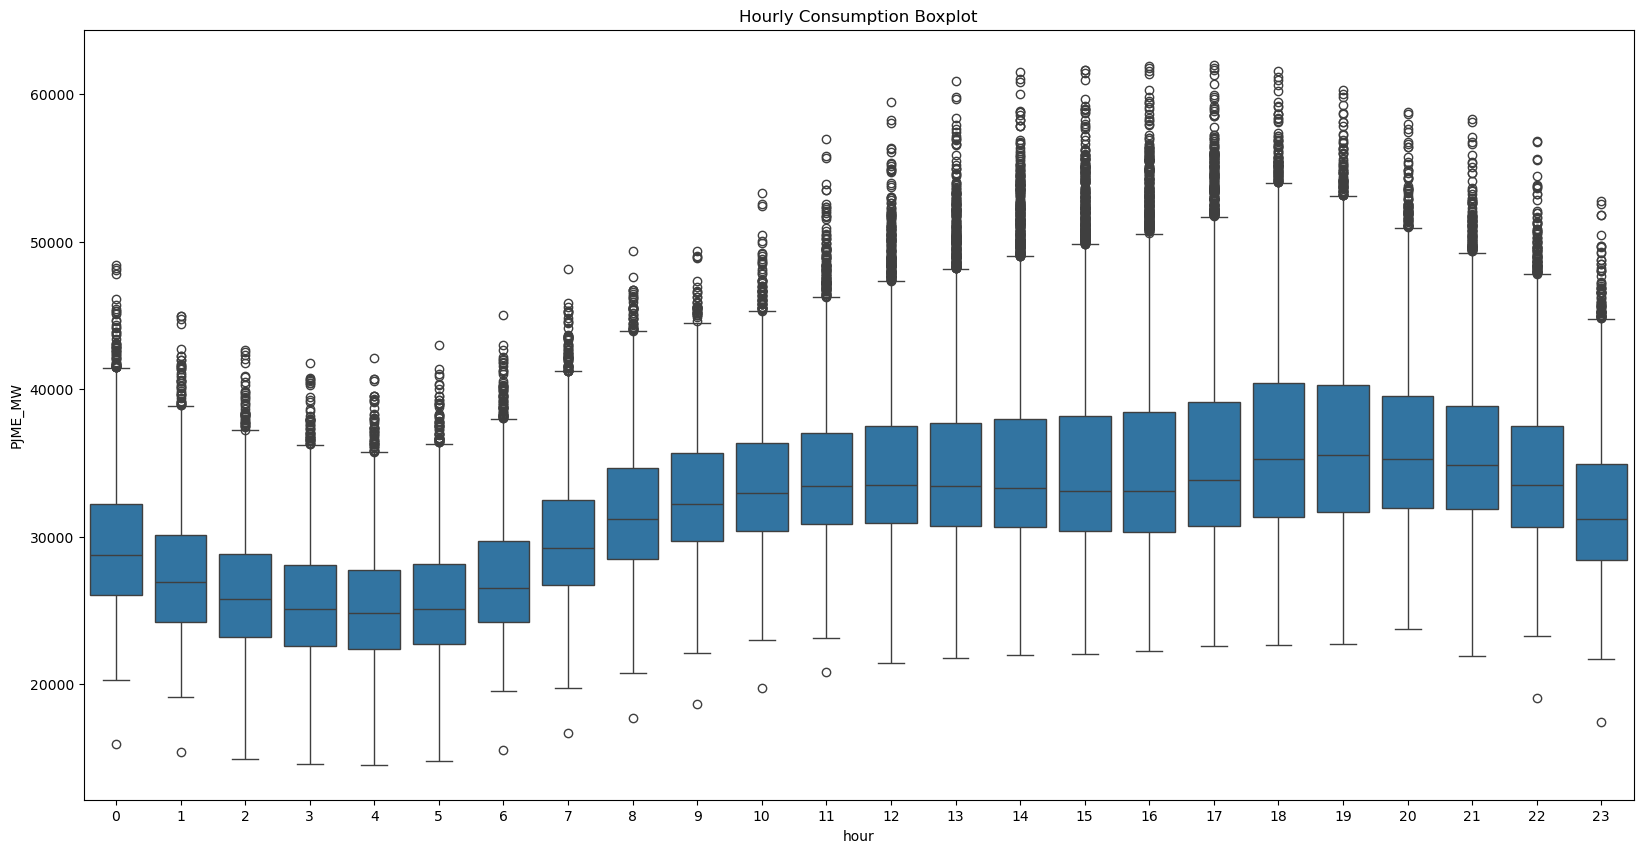

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Hourly Consumption Boxplot')

plt.show()
                       

This is a boxplot that visualizes hourly energy consumption (likely in megawatts, as indicated by the y-axis labeled "PJM_E_MW") for a specific dataset. The x-axis represents the hours of the day (0 to 23), and the y-axis shows the energy consumption values.

### Key Observations:
**Hourly Patterns**:
   - Energy consumption is lowest during early morning hours (e.g., 0–6 AM).
   - It gradually increases starting around 7–8 AM, peaks between 17–20 (5 PM–8 PM), and then decreases again late at night.


**Outliers**:
   - Outliers are more frequent during peak hours, suggesting occasional spikes or anomalies in energy usage.

